<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C1/W3/ungraded_labs/C1_W3_Lab_1_improving_accuracy_using_convolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Improving Computer Vision Accuracy using Convolutions





# Shallow Neural Network

In the previous lessons, you saw how to do fashion recognition using a neural network containing three layers -- the input layer (in the shape of the data), the output layer (in the shape of the desired output) and only one hidden layer. You experimented with the impact of different sizes of hidden layer, number of training epochs etc on the final accuracy. For convenience, here's the entire code again. Run it and take a note of the test accuracy that is printed out at the end. 

In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Setting log levels: 2 = INFO and WARNING messages are not printed

In [2]:
import tensorflow as tf

# Load the Fashion MNIST dataset
fmnist = tf.keras.datasets.fashion_mnist
(training_images, training_labels), (test_images, test_labels) = fmnist.load_data()

# Normalize the pixel values
training_images = training_images / 255.0
test_images = test_images / 255.0

In [3]:
# Define the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation=tf.nn.relu),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

# Setup training parameters
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
print(f'\nMODEL TRAINING:')
model.fit(training_images, training_labels, epochs=5)

# Evaluate on the test set
print(f'\nMODEL EVALUATION:')
test_loss = model.evaluate(test_images, test_labels)

Metal device set to: Apple M2 Pro

MODEL TRAINING:
Epoch 1/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4925 - accuracy: 0.8275
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3722 - accuracy: 0.8651
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3344 - accuracy: 0.8785
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3119 - accuracy: 0.8864
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2940 - accuracy: 0.8924

MODEL EVALUATION:
313/313 [==============================] - 1s 3ms/step - loss: 0.3501 - accuracy: 0.8745


## Convolutional Neural Network

In the model above, your accuracy will probably be about 89% on training and 87% on validation. Not bad. But how do you make that even better? One way is to use something called _convolutions_. We're not going into the details of convolutions in this notebook (please see resources in the classroom), but the ultimate concept is that they narrow down the content of the image to focus on specific parts and this will likely improve the model accuracy. 

If you've ever done image processing using a filter (like [this](https://en.wikipedia.org/wiki/Kernel_(image_processing))), then convolutions will look very familiar. In short, you take an array (usually 3x3 or 5x5) and scan it over the entire image. By changing the underlying pixels based on the formula within that matrix, you can do things like edge detection. So, for example, if you look at the above link, you'll see a 3x3 matrix that is defined for edge detection where the middle cell is 8, and all of its neighbors are -1. In this case, for each pixel, you would multiply its value by 8, then subtract the value of each neighbor. Do this for every pixel, and you'll end up with a new image that has the edges enhanced.

This is perfect for computer vision because it often highlights features that distinguish one item from another. Moreover, the amount of information needed is then much less because you'll just train on the highlighted features.

That's the concept of **Convolutional Neural Networks**. Add some layers to do convolution before you have the dense layers, and then the information going to the dense layers is more focused and possibly more accurate.

Run the code below. This is the same neural network as earlier, but this time with [Convolution](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers added first. It will take longer, but look at the impact on the accuracy.

In [18]:
class myCallback(tf.keras.callbacks.Callback):
        # Define the correct function signature for on_epoch_end
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('accuracy') is not None and logs.get('loss') < 0.40:                 
                print("\nReached 40% loss so cancelling training!")
                
                # Stop training once the above condition is met
                self.model.stop_training = True
callbacks = myCallback()

In [19]:
# Define the model
model = tf.keras.models.Sequential([
                                                         
  # Add convolutions and max pooling
  tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),

  # Add the same layers as before
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

# Print the model summary
model.summary()

# Use same settings
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
print(f'\nMODEL TRAINING:')
model.fit(training_images, training_labels, epochs=5, callbacks=[callbacks])

# Evaluate on the test set
print(f'\nMODEL EVALUATION:')
test_loss = model.evaluate(test_images, test_labels)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 1600)              0         
                                                                 
 dense_16 (Dense)            (None, 128)              

It's likely gone up to about 92% on the training data and 90% on the validation data. That's significant, and a step in the right direction!

Look at the code again, and see, step by step how the convolutions were built. Instead of the input layer at the top, you added a [Conv2D layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D). The parameters are:

1. The number of convolutions you want to generate. The value here is purely arbitrary but it's good to use powers of 2 starting from 32.
2. The size of the Convolution. In this case, a 3x3 grid.
3. The activation function to use. In this case, you used a ReLU, which you might recall is the equivalent of returning `x` when `x>0`, else return `0`.
4. In the first layer, the shape of the input data.

You'll follow the convolution with a [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layer which is designed to compress the image, while maintaining the content of the features that were highlighted by the convolution. By specifying `(2,2)` for the MaxPooling, the effect is to quarter the size of the image. Without going into too much detail here, the idea is that it creates a 2x2 array of pixels, and picks the biggest one. Thus, it turns 4 pixels into 1. It repeats this across the image, and in doing so, it halves both the number of horizontal and vertical pixels, effectively reducing the image to 25% of the original image.

You can call `model.summary()` to see the size and shape of the network, and you'll notice that after every max pooling layer, the image size is reduced in this way. 


```
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
```


Then you added another convolution and flattened the output.



```
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2)
  tf.keras.layers.Flatten(),
  
```


After this, you'll just have the same DNN structure as the non convolutional version. The same dense layer with 128 neurons, and output layer with 10 neurons as in the pre-convolution example:



```
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
```


## About overfitting

Try running the training for more epochs -- say about 20, and explore the results. But while the results might seem really good, the validation results may actually go down, due to something called _overfitting_. In a nutshell, overfitting occurs when the network learns the data from the training set really well, but it's too specialised to only that data, and as a result is less effective at interpreting other unseen data. For example, if all your life you only saw red shoes, then when you see a red shoe you would be very good at identifying it. But blue suede shoes might confuse you... and you know you should never mess with my blue suede shoes.

# Visualizing the Convolutions and Pooling

Let's explore how to show the convolutions graphically. The cell below prints the first 100 labels in the test set, and you can see that the ones at index `0`, index `23` and index `28` are all the same value (i.e. `9`). They're all shoes. Let's take a look at the result of running the convolution on each, and you'll begin to see common features between them emerge. Now, when the dense layer is training on that data, it's working with a lot less, and it's perhaps finding a commonality between shoes based on this convolution/pooling combination.

In [10]:
print(test_labels[:100])

[9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0 2 5 7 9 1 4 6 0 9 3 8 8 3 3 8 0 7
 5 7 9 6 1 3 7 6 7 2 1 2 2 4 4 5 8 2 2 8 4 8 0 7 7 8 5 1 1 2 3 9 8 7 0 2 6
 2 3 1 2 8 4 1 8 5 9 5 0 3 2 0 6 5 3 6 7 1 8 0 1 4 2]


1/1 [==============================] - 0s 6ms/step


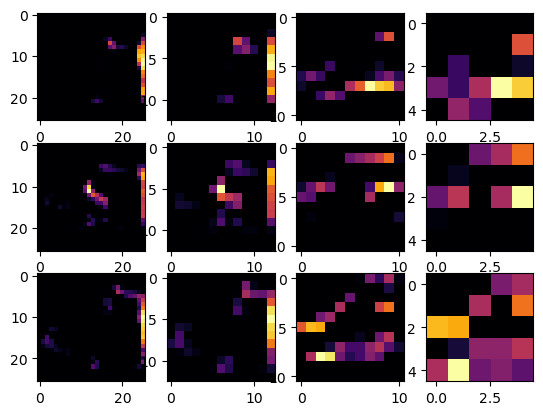

In [12]:
import matplotlib.pyplot as plt
from tensorflow.keras import models

f, axarr = plt.subplots(3,4)

FIRST_IMAGE=0
SECOND_IMAGE=23
THIRD_IMAGE=28
CONVOLUTION_NUMBER = 1

layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs = model.input, outputs = layer_outputs)

for x in range(0,4):
    f1 = activation_model.predict(test_images[FIRST_IMAGE].reshape(1, 28, 28, 1))[x]
    axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
    axarr[0,x].grid(False)
    
    f2 = activation_model.predict(test_images[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
    axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
    axarr[1,x].grid(False)
    
    f3 = activation_model.predict(test_images[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
    axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER], cmap='inferno')
    axarr[2,x].grid(False)

### EXERCISES

1. Try editing the convolutions. Change the 32s to either 16 or 64. What impact will this have on accuracy and/or training time.

2. Remove the final Convolution. What impact will this have on accuracy or training time?

3. How about adding more Convolutions? What impact do you think this will have? Experiment with it.

4. Remove all Convolutions but the first. What impact do you think this will have? Experiment with it. 

5. In the previous lesson you implemented a callback to check on the loss function and to cancel training once it hit a certain amount. See if you can implement that here.